In [1]:
##%matplotlib widget
%matplotlib notebook

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Jul 17 16:41:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   38C    P2    26W / 250W |      0MiB / 12036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   79C    P0   105W / 250W |   6407MiB / 16280MiB |     93%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

### Set up local parameters

In [4]:
n_epochs = 40

# Name is the output file name
##oldName = 'Oct11_SimpleCNN4Layer_C_100epochs_160K_lr_3em4'
##oldName = 'Oct22_SimpleCNN5Layer_C_many_epochs_160K_lr_1em4_bs64'
##oldName = 'Oct22_SimpleCNN5Layer_C_restart40epochs_240K_lr_1em4_bs64'
##oldName = 'Oct28_SimpleCNN4Layer_D_YetAnother400epochs_240K_lr_1em3_bs64'
##oldName = 'Nov11_SimpleCNN4Layer_D35_Amother200epochs_240K_lr_3em5_bs64'
##oldName = 'Nov14_SimpleCNN4Layer_D25_Another50epochs_240K_lr_3em5_bs64'
##oldName = 'Nov15_SimpleCNN4Layer_D25_Another50epochs_240K_lr_1em4_bs64_Alt_Loss_A_0p5'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother50epochs_240K_lr_1em4_bs64_Alt_Loss_A_1p0'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother50epochs_240K_lr_1em4_bs64_Alt_Loss_A_1p5'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother20epochs_240K_lr_1em4_bs64_Alt_Loss_A_2p0'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother250epochs_240K_lr_3em5_bs64_Alt_Loss_A_2p5'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother150epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0'
##oldName = 'June24_XandXsq_CNN4Layer_D35_100epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0'
oldName = 'June26_XandXsq_CNN4Layer_D15_Another40epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0'
name = 'July19_XandXsq_CNN5Layer_D15_First40epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0'

# Make an output folder named "name" (change if you want)
output = Path(name)
oldOutput = Path(oldName)
# These are the input data files to read in
trainfile = [Path('/share/lazy/schreihf/PvFinder/Aug14_80K_train.npz'),
            Path('/share/lazy/schreihf/PvFinder/Oct03_80K_train.npz'),
            Path('/share/lazy/schreihf/PvFinder/Oct03_80K2_train.npz')]
valfile = Path('/share/lazy/schreihf/PvFinder/Oct03_20K_val.npz')

# Size of batches
batch_size = 64

# How fast to learn
learning_rate = 1e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##from model.models_mds_C import TwoFeatures_CNN4Layer_D15 as Model
from model.models_mds_C import TwoFeature_CNN5Layer_A as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
# Training dataset. You can put as many files here as desired.

##  set the optio load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('data/Aug14_80K_train.h5',
                            'data/Oct03_80K_train.h5',
##                          'data/Oct03_80K2_train.h5',
                            batch_size=batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True)

# Validation dataset. You can slice to reduce the size.
val_loader = collect_data('data/Oct03_20K_val.h5',
                          batch_size=batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True)

Loading data...
Loaded data/Aug14_80K_train.h5 in 13.85 s
Loaded data/Oct03_80K_train.h5 in 13.94 s
Constructing 160000 event dataset took 9.393 s
Loading data...
Loaded data/Oct03_20K_val.h5 in 3.771 s
Constructing 9984 event dataset took 0.5456 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()
loss = Loss(epsilon=1e-5,coefficient=3.0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [12]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
pretrained_dict = torch.load('./June26_XandXsq_CNN4Layer_D15_Another40epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0/June26_XandXsq_CNN4Layer_D15_Another40epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0_final.pyt')
model_dict = model.state_dict()
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict
model.load_state_dict(pretrained_dict,strict=False)

output =  July19_XandXsq_CNN5Layer_D15_First40epochs_160K_lr_1em4_bs64_Alt_Loss_A_3p0


In [13]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


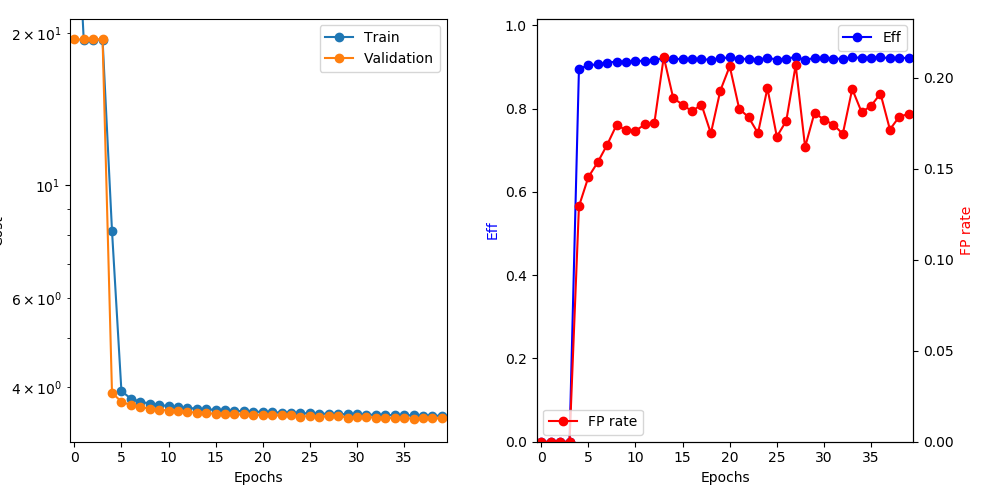

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 2500, val = 156


Epoch 0: train=45.3297, val=19.418, took 49.054 s
  Validation Found 0 of 54700, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 1: train=19.3999, val=19.4177, took 47.162 s
  Validation Found 0 of 54700, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 2: train=19.3982, val=19.4176, took 46.727 s
  Validation Found 0 of 54700, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 3: train=19.3978, val=19.4176, took 47.036 s
  Validation Found 0 of 54700, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 4: train=8.1431, val=3.90017, took 47.49 s
  Validation Found 48983 of 54700, added 1292 (eff 89.55%) (0.129 FP/event)


Epoch 5: train=3.92844, val=3.74029, took 47.56 s
  Validation Found 49443 of 54700, added 1452 (eff 90.39%) (0.145 FP/event)


Epoch 6: train=3.7946, val=3.68471, took 47.142 s
  Validation Found 49585 of 54700, added 1534 (eff 90.65%) (0.154 FP/event)


Epoch 7: train=3.74367, val=3.65174, took 46.406 s
  Validation Found 49800 of 54700, added 1630 (eff 91.04%) (0.163 FP/event)


Epoch 8: train=3.7093, val=3.62814, took 46.566 s
  Validation Found 49936 of 54700, added 1739 (eff 91.29%) (0.174 FP/event)


Epoch 9: train=3.6872, val=3.61038, took 46.516 s
  Validation Found 49939 of 54700, added 1709 (eff 91.30%) (0.171 FP/event)


Epoch 10: train=3.66834, val=3.59421, took 46.348 s
  Validation Found 50003 of 54700, added 1706 (eff 91.41%) (0.171 FP/event)


Epoch 11: train=3.65121, val=3.58507, took 46.195 s
  Validation Found 50056 of 54700, added 1741 (eff 91.51%) (0.174 FP/event)


Epoch 12: train=3.63864, val=3.57303, took 45.798 s
  Validation Found 50104 of 54700, added 1748 (eff 91.60%) (0.175 FP/event)


Epoch 13: train=3.62586, val=3.56173, took 46.127 s
  Validation Found 50411 of 54700, added 2111 (eff 92.16%) (0.211 FP/event)


Epoch 14: train=3.61544, val=3.55579, took 46.304 s
  Validation Found 50291 of 54700, added 1886 (eff 91.94%) (0.189 FP/event)


Epoch 15: train=3.60666, val=3.54075, took 46.499 s
  Validation Found 50275 of 54700, added 1849 (eff 91.91%) (0.185 FP/event)


Epoch 16: train=3.59999, val=3.53844, took 46.525 s
  Validation Found 50263 of 54700, added 1813 (eff 91.89%) (0.182 FP/event)


Epoch 17: train=3.59141, val=3.53315, took 46.217 s
  Validation Found 50228 of 54700, added 1850 (eff 91.82%) (0.185 FP/event)


Epoch 18: train=3.58286, val=3.53323, took 46.452 s
  Validation Found 50185 of 54700, added 1692 (eff 91.75%) (0.169 FP/event)


Epoch 19: train=3.57907, val=3.52119, took 46.512 s
  Validation Found 50375 of 54700, added 1926 (eff 92.09%) (0.193 FP/event)


Epoch 20: train=3.57114, val=3.52259, took 46.488 s
  Validation Found 50481 of 54700, added 2060 (eff 92.29%) (0.206 FP/event)


Epoch 21: train=3.56599, val=3.51517, took 46.858 s
  Validation Found 50336 of 54700, added 1828 (eff 92.02%) (0.183 FP/event)


Epoch 22: train=3.56119, val=3.51807, took 46.579 s
  Validation Found 50272 of 54700, added 1780 (eff 91.90%) (0.178 FP/event)


Epoch 23: train=3.55699, val=3.52022, took 46.118 s
  Validation Found 50154 of 54700, added 1693 (eff 91.69%) (0.17 FP/event)


Epoch 24: train=3.55179, val=3.49702, took 46.445 s
  Validation Found 50464 of 54700, added 1940 (eff 92.26%) (0.194 FP/event)


Epoch 25: train=3.54836, val=3.50788, took 46.585 s
  Validation Found 50167 of 54700, added 1674 (eff 91.71%) (0.168 FP/event)


Epoch 26: train=3.54604, val=3.49442, took 46.733 s
  Validation Found 50322 of 54700, added 1760 (eff 92.00%) (0.176 FP/event)


Epoch 27: train=3.54263, val=3.50004, took 46.2 s
  Validation Found 50541 of 54700, added 2066 (eff 92.40%) (0.207 FP/event)


Epoch 28: train=3.53845, val=3.5082, took 47.456 s
  Validation Found 50155 of 54700, added 1617 (eff 91.69%) (0.162 FP/event)


Epoch 29: train=3.53462, val=3.48153, took 47.12 s
  Validation Found 50412 of 54700, added 1805 (eff 92.16%) (0.181 FP/event)


Epoch 30: train=3.53136, val=3.48576, took 46.77 s
  Validation Found 50383 of 54700, added 1767 (eff 92.11%) (0.177 FP/event)


Epoch 31: train=3.52876, val=3.48687, took 46.877 s
  Validation Found 50331 of 54700, added 1740 (eff 92.01%) (0.174 FP/event)


Epoch 32: train=3.52629, val=3.48246, took 46.222 s
  Validation Found 50280 of 54700, added 1689 (eff 91.92%) (0.169 FP/event)


Epoch 33: train=3.52314, val=3.47349, took 46.493 s
  Validation Found 50522 of 54700, added 1935 (eff 92.36%) (0.194 FP/event)


Epoch 34: train=3.52028, val=3.47496, took 46.509 s
  Validation Found 50406 of 54700, added 1808 (eff 92.15%) (0.181 FP/event)


Epoch 35: train=3.51896, val=3.47251, took 46.522 s
  Validation Found 50471 of 54700, added 1843 (eff 92.27%) (0.185 FP/event)


Epoch 36: train=3.51715, val=3.46637, took 46.493 s
  Validation Found 50524 of 54700, added 1910 (eff 92.37%) (0.191 FP/event)


Epoch 37: train=3.51404, val=3.47427, took 46.459 s
  Validation Found 50354 of 54700, added 1713 (eff 92.05%) (0.172 FP/event)


Epoch 38: train=3.512, val=3.46954, took 46.498 s
  Validation Found 50432 of 54700, added 1784 (eff 92.20%) (0.179 FP/event)


Epoch 39: train=3.5111, val=3.46873, took 46.415 s
  Validation Found 50405 of 54700, added 1798 (eff 92.15%) (0.18 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/data/conda/envs/anaconda/lib/python3.7/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->['epoch', 'eff_val']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Save the plot above:

<IPython.core.display.Javascript object>


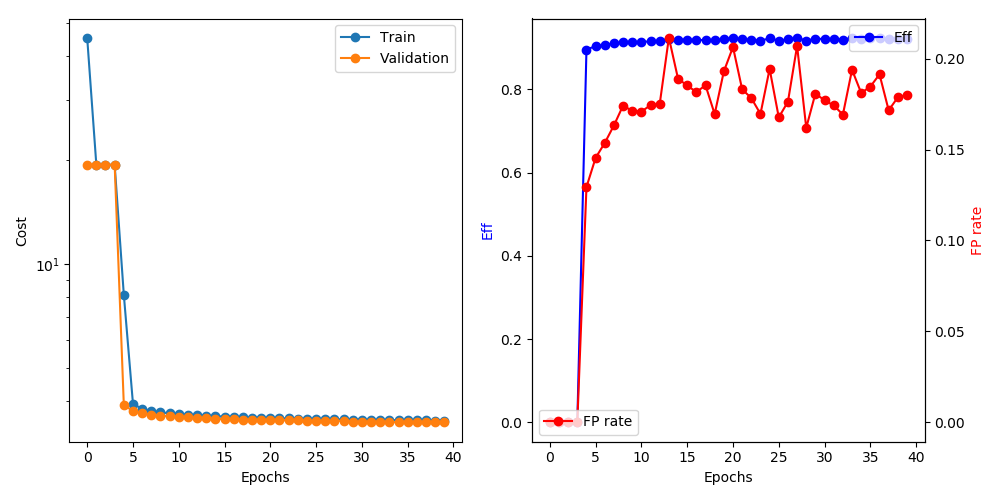

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [19]:
quit()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
